In [29]:
import jax
import jax.numpy as jnp
from jax import jit
jax.config.update("jax_enable_x64", True)


from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline 

%load_ext autoreload                                                                                                                                                                                            
%autoreload 


import computational_OT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### log-domain Sinkhorn using numpy

In [30]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [31]:
def generate_data(N):
    """
     N is a list of the size of the data on x and y
    """
    x = np.random.rand( 2,N[0] )-0.5
    theta = 2*np.pi*np.random.rand( 1,N[1] )
    r = 0.8+.2*np.random.rand( 1,N[1] )
    y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )
    return x,y

In [32]:
N = [ 500, 600 ]
x,y = generate_data(N)
a = normalize(np.ones(N[0]))
b = normalize(np.ones(N[1]))
# Log domain Sinkhorn
print("Log domain Sinkhorn.... ")
results_logSinkhorn = []
times_logSinkhorn   = []
logsinkhornP        = []
epsilons = [ 0.1 , 0.05 , 0.01, 0.005,  0.001 ]
  
#Cost matrix
C = distmat(x,y)
for eps in epsilons:

  print( "Sinkhorn for epsilon = "+str(eps)+":" )    
  
  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

  start = time.time()
  logsinkhorn = computational_OT.Log_domainSinkhorn(a, b, C, eps)
  output = logsinkhorn.update( niter = 500 )
  results_logSinkhorn.append( output )
  end = time.time()
  times_logSinkhorn.append(1e-3*(end-start) )
  logsinkhornP.append(GetP(np.exp(output['potential_f']/eps), np.exp(-C/eps),np.exp(output['potential_g']/eps)))

Log domain Sinkhorn.... 
Sinkhorn for epsilon = 0.1:
Doing for ( 500 600 ).
 |- Iterating


Terminating after iteration:  123
Sinkhorn for epsilon = 0.05:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  254
Sinkhorn for epsilon = 0.01:
Doing for ( 500 600 ).
 |- Iterating
Terminating after maximal number of iterations:  500
Sinkhorn for epsilon = 0.005:
Doing for ( 500 600 ).
 |- Iterating
Terminating after maximal number of iterations:  500
Sinkhorn for epsilon = 0.001:
Doing for ( 500 600 ).
 |- Iterating
Terminating after maximal number of iterations:  500


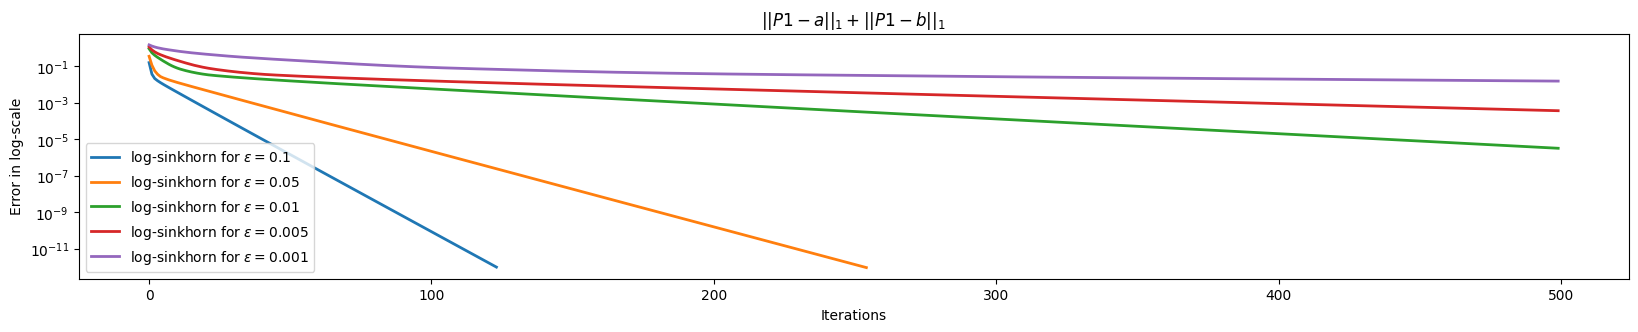

In [33]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len( results_logSinkhorn) ):
  error = np.asarray( results_logSinkhorn[i]['error'] )
  plt.plot( error, label = 'log-sinkhorn for $\epsilon=$'+ str(epsilons[i]) , linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")
plt.show()


### log-domain Sinkhorn using JAX

In [34]:

@jit
def distmat_JAX(x, y):
    return jnp.sum(x**2, axis=0)[:, None] + jnp.sum(y**2, axis=0)[None, :] - 2 * x.transpose().dot(y)

# Function to normalize a vector
normalize_JAX = lambda a: a / jnp.sum(a)

# Function to compute P
@jit
def GetP_JAX(u, K, v):
    return u[:, None] * K * v[None, :]

# Function to plot points
def plotp(x, col, plt, scale=200, edgecolors="k"):
    return plt.scatter(x[0, :], x[1, :], s=scale, edgecolors=edgecolors, c=col, cmap='plasma', linewidths=2)


In [35]:
def generate_data_JAX(N):
    """
     N is a list of the size of the data on x and y
    """
    shape = (2, N[0])
    key_x, key_y = jax.random.split(jax.random.PRNGKey(42), 2)  # Splitting the PRNGKey
    random_array_uniform_x = jax.random.uniform(key_x, shape=shape) 
    x = random_array_uniform_x  -0.5
    shape = (1, N[1])
    random_array_uniform_y = jax.random.uniform(key_y, shape=shape)
    theta = 2*jnp.pi*random_array_uniform_y
    r = 0.8+.2*random_array_uniform_y
    y = jnp.vstack( ( r*jnp.cos( theta ),r*jnp.sin( theta ) ) )
    return x,y

In [36]:
N = [ 500, 600 ]
epsilons = [ 0.1 , 0.05 , 0.01, 0.005,  0.001 ]
x,y = generate_data_JAX(N)
a = normalize_JAX(jnp.ones(N[0]))
b = normalize_JAX(jnp.ones(N[1]))

# Log domain Sinkhorn
print("Log domain Sinkhorn.... ")
results_logSinkhorn_JAX = []
times_logSinkhorn_JAX   = []
logsinkhornP_JAX     = []      

#Cost matrix
C = distmat_JAX(x,y)  
for eps in epsilons:

  print( "Sinkhorn for epsilon = "+str(eps)+":" )    
  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

  start = time.time()
  output = computational_OT.logdomain_sinkhorn_JAX.update( a, b, C, eps)
  results_logSinkhorn_JAX.append( output )
  end = time.time()
  times_logSinkhorn_JAX.append(1e-3*(end-start) )
  logsinkhornP_JAX.append(GetP_JAX(jnp.exp(output['potential_f']/eps), jnp.exp(-C/eps), jnp.exp(output['potential_g']/eps)))

Log domain Sinkhorn.... 
Sinkhorn for epsilon = 0.1:
Doing for ( 500 600 ).
 |- Iterating


Terminating after iteration:  116
Sinkhorn for epsilon = 0.05:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  245
Sinkhorn for epsilon = 0.01:
Doing for ( 500 600 ).
 |- Iterating
Terminating after maximal number of iterations:  500
Sinkhorn for epsilon = 0.005:
Doing for ( 500 600 ).
 |- Iterating
Terminating after maximal number of iterations:  500
Sinkhorn for epsilon = 0.001:
Doing for ( 500 600 ).
 |- Iterating
Terminating after maximal number of iterations:  500


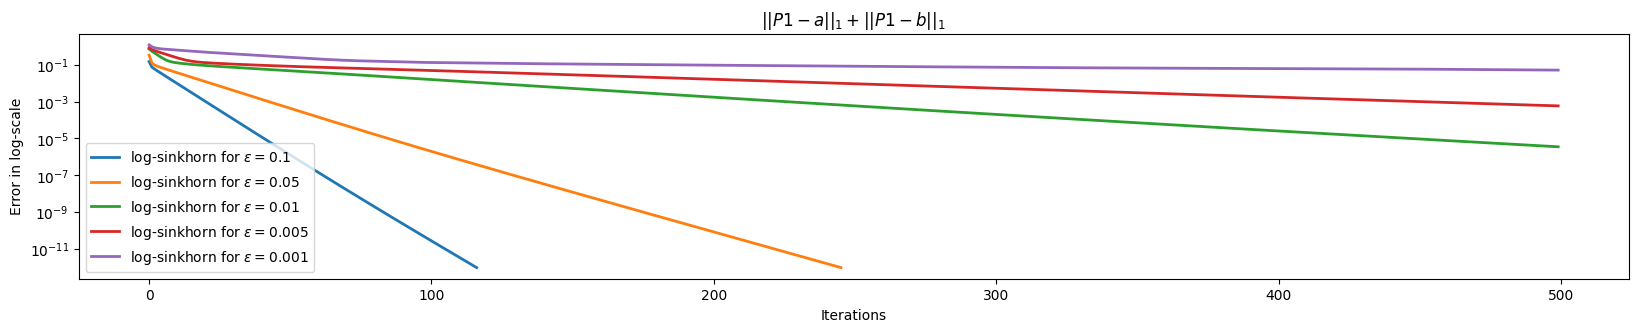

In [37]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len( results_logSinkhorn_JAX ) ):
  error = jnp.asarray( results_logSinkhorn_JAX[i]['error'] )
  plt.plot( error, label = 'log-sinkhorn for $\epsilon=$'+ str(epsilons[i]) , linewidth = 2 )
plt .yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")
plt.show()

### Time plot

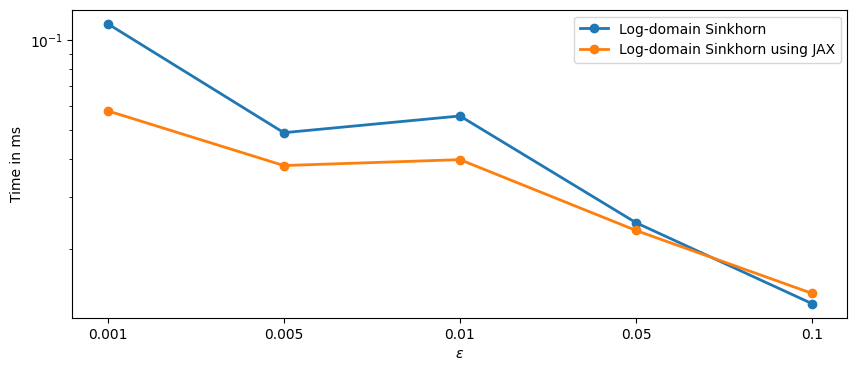

In [38]:
plt.figure(figsize = (10,4))
plt.plot(list(range(len(epsilons))), times_logSinkhorn[::-1], label = 'Log-domain Sinkhorn', marker='o', linewidth = 2)
plt.plot(list(range(len(epsilons))), times_logSinkhorn_JAX[::-1], label = 'Log-domain Sinkhorn using JAX', marker='o', linewidth = 2)
plt.legend()
plt.xticks(list(range(len(epsilons))), epsilons[::-1])
plt.xlabel("$\epsilon$")
plt.yscale('log')
plt.ylabel("Time in ms")
plt.show()